# Overview

The goal is to compute a maximum likelihood estimate (MLE) for a particular compound Poisson distribution. First we setup some definitions. Let

$$ N\sim \text{Poisson}(\lambda)  \text{, and } X_j \stackrel{i.i.d.}{\sim} \text{Geometric}(1-p),$$

where the range  of the $X_j$ starts at 0. The parameters \\(\lambda\\) and \\(p\\) are assumed to be unknown. We can think of each \\(X_j\\) as the number of successes before the first failure, where success occurs with probability \\(p\\).

We cannot observe \\(N\\) or the \\(X_j\\). Instead, we only observe \\(n\\) i.i.d. copies of \\(Y\\), where

$$ Y = \sum_{j=1}^N X_j.$$

If $N=0$, we take $Y$ to be 0. Such a \\(Y\\) might arise in biology. Perhaps transcription of a gene occurs according to a Poisson process, and once transcription begins, we model the number of mRNA transcripts with a geometric random variable.

Let \\(\{Y_i\}_{i=1}^n\\) denote the i.i.d. copies of \\(Y\\). The goal is to find the maximum likelihood estimates of \\(\lambda\\) and \\(p\\) in a reasonable amount of time without using approximations (other than numerical error). In other words, we want to compute

$$\underset{\lambda,p}{\arg\max} \sum_{i=1}^n \log P(Y=y_i; \lambda, p)$$

subject to the constraints \\(\lambda \ge 0\\) and \\(\epsilon \le p \le 1 - \epsilon\\) for some chosen \\(\epsilon \in (0, 1/2)\\).

The rest of this document is split into multiple sections. First, we will write down the expectation, variance, and probability mass function (p.m.f.) of \\(Y\\) and its derivatives. Second, we will check the p.m.f. by simulating observations of \\(Y\\)  and comparing the corresponding histogram to the p.m.f. values. Finally, we will use SciPy's optimization library to compute the MLE.

It seems that this idea can be extended to a generalized linear model, where the parameters \\(\lambda\\) and \\(p\\) depend on known covariates and unknown parameters.

# The expectation and variance

The expectation and variance are easy to derive, so we start with those. The law of total expectation implies that

$$
\begin{align*}
\mathbb{E}[Y] &= \mathbb{E}[\mathbb{E}[Y | N]] \\
&= \mathbb{E}[N p / (1-p)] \\
&= \frac{\lambda p }{1-p} \\
\end{align*}
$$

Similarly, from law of total variance 

$$
\begin{align*}
\text{Var}(Y) &= \mathbb{E}[\text{Var}(Y|N)] + \text{Var}(\mathbb{E}[Y|N]) \\
&= \mathbb{E}[N p / (1-p)^2] + \text{Var}(N p/(1-p)) \\
&= \frac{\lambda p}{(1-p)^2} + \frac{\lambda p^2}{(1-p)^2} \\
&= \frac{\lambda p(1+p)}{(1-p)^2} \\
\end{align*}
$$

Before we proceed, we should state the following fact, because it will be useful later. A finite sum of i.i.d. geometric random variables follows a [negative binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution#Distribution_of_a_sum_of_geometrically_distributed_random_variables). Therefore, if we condition on \\(N\\), \\(Y\\) is a negative binomial random variable with parameters \\(N\\) and \\(p\\).

Next we check the above moment computations through simulation. We will also show that the negative binomial construction gives the same results. Since there are different parameterizations of the geometric and negative binomial distributions, it is always a good idea to make sure our parameterizations are consistent. If the expectation and variance are correct, then chances are the parameterizations are right.


true expectation: 20.000000000000004
true variance: 180.00000000000009

-------------------------

GEOMETRIC CONSTRUCTION
sample mean : 20.05853
sample variance : 179.25324423909996
standard error: 0.042338309394577854

-------------------------

NEGATIVE BINOMIAL CONSTRUCTION
sample mean: 19.94988
sample variance: 179.8868879856
standard error: 0.04241307439759584

-------------------------

slope of the line: 0.9966968070223494


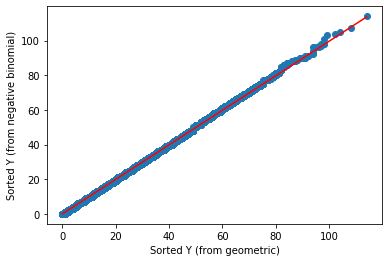

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

lmbda = 5
p = 0.8
samples = 10**5

np.random.seed(0)

N = np.random.poisson(lmbda, size=samples)

###########################
# construct the Y observations with geometric random variables
###########################

#the -1 is so they start from 0 instead of 1
geom = np.random.geometric(1-p, size=np.sum(N)) - 1 
Y_geom = np.array([np.sum(arr) for arr in np.split(geom, np.cumsum(N))[:-1]], dtype=np.int)

###########################
# construct the Y observations with negative binomial random variables
###########################

#np.random.negative_binomial(N, p) does not handle zeros values in N, so we need to work around it
altered_N = np.copy(N)
np.putmask(altered_N, N == 0, 1)
Y_neg_binom = np.random.negative_binomial(altered_N, 1-p)
np.putmask(Y_neg_binom, N == 0, 0) 

###########################
# display the results
###########################

true_expect = lmbda * p / (1-p)
true_var = lmbda * p * (1+p) / (1-p)**2

print(f'true expectation: {true_expect}')
print(f'true variance: {true_var}')
print('\n-------------------------\n')

print('GEOMETRIC CONSTRUCTION')
print(f'sample mean : {np.mean(Y_geom)}')
print(f'sample variance : {np.var(Y_geom)}')
print(f'standard error: {np.std(Y_geom)/np.sqrt(samples)}')
print('\n-------------------------\n')

print('NEGATIVE BINOMIAL CONSTRUCTION')
print(f'sample mean: {np.mean(Y_neg_binom)}')
print(f'sample variance: {np.var(Y_neg_binom)}')
print(f'standard error: {np.std(Y_neg_binom)/np.sqrt(samples)}')
print('\n-------------------------\n')

#make a QQ plot for the two constructions, should roughly see a line with slope 1
#good for detecting subtle errors, especially in the tails
sorted_Y_geom = np.sort(Y_geom)
sorted_Y_neg_binom = np.sort(Y_neg_binom)

slope = np.linalg.lstsq(np.reshape(sorted_Y_geom, (-1, 1)), sorted_Y_neg_binom, rcond=None)[0][0]

plt.scatter(sorted_Y_geom, sorted_Y_neg_binom)
plt.plot(sorted_Y_geom, slope * sorted_Y_geom, color='r')
plt.xlabel('Sorted Y (from geometric)')
plt.ylabel('Sorted Y (from negative binomial)')
print(f'slope of the line: {slope}')

# Probability mass function

We want to compute $P(Y=y)$ for $y\in\mathbb{Z}_{\ge 0}$. We previously defined $Y$ as

$$ Y = \sum_{j=1}^N X_j,$$

where $N\sim\text{Poisson}(\lambda)$ and $X_j \stackrel{i.i.d.}{\sim} \text{Geometric}(1-p)$. Therefore

$$
\begin{align*}
P(Y=y) &= \sum_{\eta=0}^\infty P(Y=y, N=\eta)\\
&= \sum_{\eta=0}^\infty P(Y=y | N=\eta) P(N=\eta)
\end{align*}
$$

Recall that, when conditioned on $N$, $Y$ follows a negative binomial distribution with parameters $N$ and $p$. So we can rewrite the probability as

$$
\begin{align*}
P(Y=y) &= \sum_{\eta=0}^\infty \binom{y+\eta-1}{y} (1-p)^\eta p^y \frac{\lambda^\eta e^{-\lambda}}{\eta!}\\
\end{align*}
$$

Unfortunately the above expression involves an infinite series. We would like to evaluate it exactly (up to machine precision), and not use a truncated series or any another approximation. Instead we will use a [marked Poisson process](https://en.wikipedia.org/wiki/Poisson_point_process#Marked_Poisson_point_process) to arrive at an equivalent finite series.

Let $Y(t)$ be a unit-rate Poisson process, and we consider the process up to time $\lambda$. At each jump, imagine that we flip a biased coin, which comes up heads with probability $p$. If it is heads, we mark the point with a "1", and "0" if it is tails. The geometric random variables $X_j$ can be though of as the number of heads in a series of flips until the first tails appears. Therefore, the Poisson process points marked with a 0 correspond to when $X_j = 0$. When a point is marked with a 1, that corresponds to when $X_j \ge 1$.

Since the coin flips are independent, the points marked with a 1 form a Poisson process with rate $p$, denoted $Y_1(t)$. Similarly, the points marked with zero form a Poisson process with rate $1-p$, denoted $Y_0(t)$. The two processes are independent. For more info see [this Wikipedia page](https://en.wikipedia.org/wiki/Poisson_point_process#Marked_Poisson_point_process).

The points of $Y_0(t)$ correspond to when $X_j=0$, so we can rewrite the original variable of interest $Y$ as

$$Y = \sum_{j=1}^{Y_1(\lambda)} \tilde{X}_j$$

where $\tilde{X}_j \stackrel{i.i.d.}{\sim} \text{Geometric}(1-p)$ and we use the parameterization of the geometric distribution where $X_j \ge 1$. If $Y_1(\lambda) = 0$, we take $Y$ to be 0. Therefore

$$P(Y=0) = P(Y_1(\lambda) = 0) = \frac{e^{-\lambda p} (\lambda p)^0}{0!} = e^{-\lambda p}.$$

Suppose $y \ge 1$. Since $\tilde{X}_j \ge 1$, we must have $Y_1(\lambda) \le y$. This is the key difference between this representation and the previous one, because earlier we did not have a bound on $N$. Thus we have

Conditioned on $Y_1(\lambda)$,
$$
Y \sim Y_1(\lambda) + \text{NB}(Y_1(\lambda), p),
$$

and therefore
$$
\begin{align*}
P(Y=y) &= \sum_{\eta=1}^y P(Y=y | Y_1(\lambda)=\eta) P(Y_1(\lambda) = \eta)\\
&= \sum_{\eta=1}^y \underbrace{\binom{y - 1}{y-\eta} (1-p)^\eta p^{y-\eta} \frac{e^{\lambda p}(\lambda p)^\eta}{\eta!}}_{a_\eta(y)}
\end{align*}
$$

Note the definition of $a_\eta(y)$, because we will refer back to it soon. If we observe realizations of $Y$, denoted $\{y_i\}_{i=1}^n$, then the log-likelihood is
$$
\ell(\lambda,p;y_1,\ldots,y_n) = \sum_{i=1}^n \log P(Y=y_i).
$$

To find the maximum likelihood estimate, it helps to have the partial derivatives with respect to $\lambda$ and $p$. Find the derivatives is straightforward, so we just write them here:

$$
\frac{\partial \ell}{\partial \lambda} =
\sum_{i=1}^n
\begin{cases}
-\frac{pe^{-\lambda p}}{P(Y=y_i)}, & y = 0\\
-p + \frac{1}{\lambda}\frac{\sum_{\eta=1}^{y_i} \eta a_\eta(y_i)}{P(Y=y_i)}, & y \ge 1
\end{cases}
$$

and other partial derivative is

$$
\frac{\partial \ell}{\partial p} =
\sum_{i=1}^n
\begin{cases}
-\frac{\lambda e^{-\lambda p}}{P(Y=y_i)}, & y = 0\\
-\lambda + \frac{\sum_{\eta=1}^{y_i} \left(\frac{y}{p} - \frac{\eta}{1-p}\right) a_\eta(y_i)}{P(Y=y_i)}, & y \ge 1
\end{cases}.
$$

### Next we check the probability mass function by comparing it to a histogram based on simulated observations.

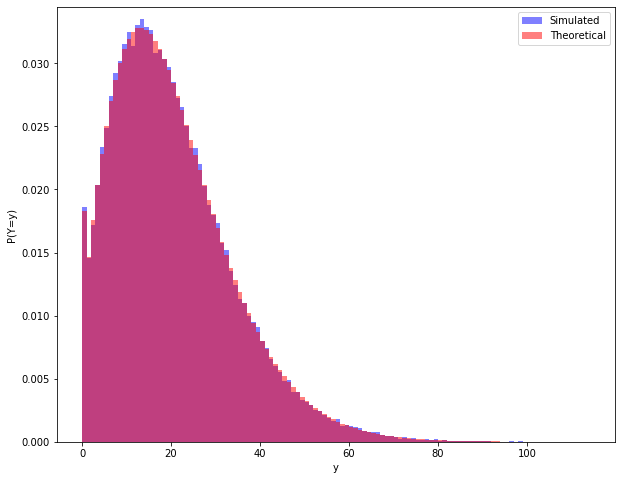

In [2]:
from scipy.stats import nbinom
from scipy.stats import poisson
import functools

#using the counts speeds up the calculations a lot, especially since we need to
#recompute the log-likelihood and its gradient many times when finding the MLE
Y_counts = {}
for y in Y_neg_binom:
    if y in Y_counts:
        Y_counts[y] += 1
    else:
        Y_counts[y] = 1

@functools.lru_cache(maxsize=None)
def get_prob(y, lmbda, p):
    assert(y >= 0)
    if y == 0:
        return np.exp(-lmbda*p), None
    n = np.arange(1, y+1)
    a_n = nbinom.pmf(y-n, n, 1-p) * poisson.pmf(n, lmbda * p)
    return np.sum(a_n), a_n

y_range = np.arange(0, np.max(Y_neg_binom)+1)
pmf = np.zeros(len(y_range))
pmf[0] = np.exp(-lmbda*p)

for i,y in enumerate(y_range[1:]):
    pmf[i+1],_ = get_prob(y, lmbda, p)
    
plt.figure(figsize=(10,8))
plt.hist(Y_neg_binom, bins=y_range, density=True, color='b', alpha=0.5, label='Simulated')
plt.hist(y_range, bins=y_range, weights=pmf, color='r', alpha=0.5, density=True, label='Theoretical')
plt.ylim(0, np.max(pmf)*1.05)
plt.xlabel('y')
plt.ylabel('P(Y=y)')
plt.legend()
plt.show()

### Here we check the derivative computations by using a finite difference approximation.

In [3]:
def get_log_likelihood(lmbda, p):
    log_likelihood = 0.
    for y, count in Y_counts.items():
        p_y, _ = get_prob(y, lmbda, p)
        log_likelihood += count * np.log(p_y)
    return log_likelihood

def get_grad_log_likelihood(lmbda, p):
    lmbda_deriv = 0.
    p_deriv = 0.
    
    for y,count in Y_counts.items():
        p_y, a_n = get_prob(y, lmbda, p)
        
        if y == 0:
            common_term = -count * np.exp(-lmbda*p) / p_y
            lmbda_deriv += p * common_term
            p_deriv += lmbda * common_term
        else:
            weights = np.arange(1, len(a_n)+1)
            
            lmbda_numerator = np.dot(weights, a_n)
            lmbda_deriv += count * (-p + lmbda_numerator / (lmbda * p_y))
            
            p_numerator = np.dot(y / p - weights / (1 - p), a_n)
            p_deriv += count * (-lmbda + p_numerator / p_y)
            
    return np.array([lmbda_deriv, p_deriv])

def get_finite_diff_approx(h):
    probs_minus = np.zeros(len(Y_neg_binom))
    probs_plus = np.zeros(len(Y_neg_binom))
    
    for i,y in enumerate(Y_neg_binom):
        probs_minus[i], _ = get_prob(y, lmbda - h/2., p)
        probs_plus[i], _ = get_prob(y, lmbda + h/2., p)
        
    lmbda_fd = np.sum(np.log(probs_plus) - np.log(probs_minus)) / h
    
    for i,y in enumerate(Y_neg_binom):
        probs_minus[i], _ = get_prob(y, lmbda, p - h/2.)
        probs_plus[i], _ = get_prob(y, lmbda, p + h/2.)
        
    p_fd = np.sum(np.log(probs_plus) - np.log(probs_minus)) / h
    
    return np.array([lmbda_fd, p_fd])
    
grad = get_grad_log_likelihood(lmbda, p)
fd_approx = get_finite_diff_approx(0.00001)

print(f'true gradient: {grad}')
print(f'finite diff. approx.: {fd_approx}')

true gradient: [ -119.64372045 -3273.90698863]
finite diff. approx.: [ -119.64372198 -3273.90715246]


# Numerically computing the maximum likelihood estimate

Since we can compute the log-likelihood and its gradient, we can use a numerical optimization routine to find the maximum likelihood estimate. There are some constraints we need to enforce, namely 
$$
\lambda \ge 0, \text{ and } p\in(0,1).
$$

We do not allow $p=0$, because some of the terms become undefined, and it is only interesting in the trivial case where $y_i =0$ for all $i$. Note that if $y_i=0$, then we cannot distinguish beteween $\lambda=0$ and $p=0$.

We will not concern ourselves much with identifiability and consistency of the MLE estimate. That said, if the expectation and variance of $Y$ is the same both two sets of parameters: $(\lambda,p)$ and $(\tilde{\lambda},\tilde{p})$, then it is easy to show that $\lambda = \tilde{\lambda}$ and $p = \tilde{p}$. Showing that the two sets of parameters have different likelihoods appears to be more complicated, and it is not a major concern since we just want to see if the numerical method converges to somewhere near the true parameters.

As for $p=1$, we have $Y=\infty$ almost surely (if $\lambda > 0$), so we also disregard that case. Therefore we fix a small $\epsilon > 0$, and impose the constraint $\epsilon \le p \le 1-\epsilon$.

We should exploit the fact that all of our constraints are simple box constraints, and use an appropriate solver. The `scipy.optimize` package has the *L-BFGS-B* solver, which should converge quickly and it handles box constraints.

Next we compute the MLE, and compare the difference between using an arbitrary strating value and a "warm-start". By warm-strat, we mean starting at the method-of-moments estimate of $\lambda$ and $p$.

Let $\bar{y}$ be the sample mean of the $\{y_i\}_{i=1}^n$, and let $\hat{\sigma}^2$ be the sample variance. Then the method-of-moments estimates are

$$
\hat{p} = \frac{\hat{\sigma}^2 - \bar{y}}{\hat{\sigma}^2 + \bar{y}}
$$

$$
\hat{\lambda} = \frac{\bar{y}(1-\hat{p})}{\hat{p}}
$$


We should always check that both $\hat{p}$ and $\hat{\lambda}$ are feasible (some solvers might complain). Often using warm-start is much faster, in that it takes fewer iterations to converge.

In [4]:
import scipy.optimize as opt

eps = 0.000001

def get_mle(x0):
    print(f'x0: {x0}')
    res = opt.minimize(lambda x: -get_log_likelihood(x[0], x[1]),
                       x0,
                       method='L-BFGS-B',
                       jac=lambda x: -get_grad_log_likelihood(x[0], x[1]),
                       bounds=[(0,None), (eps, 1-eps)],
                       callback=lambda x: print(f'x: {x}'))

    if not res['success']:
        raise RuntimeError('failed to converge')

    print()
    print(f'converged to: {res["x"]}')
    print(f'iterations: {res["nit"]}')
    return res

print('getting the MLE without a warm-start\n')
x0 = np.array([5, 0.5])
res = get_mle(x0)
print('\n-----------------------\n')

print('getting the MLE with a warm-start\n')
sample_mean_y = np.mean(Y_neg_binom)
sample_var_y = np.var(Y_neg_binom)
p_hat_mom = (sample_var_y - sample_mean_y) / (sample_var_y + sample_mean_y)
lmbda_hat_mom = sample_mean_y * (1 - p_hat_mom) / p_hat_mom
x0 = np.array([lmbda_hat_mom, p_hat_mom])
res = get_mle(x0)
print('\n-----------------------\n')

print(f'true parameters: {np.array([lmbda, p])}')

getting the MLE without a warm-start

x0: [5.  0.5]
x: [6.         0.50000766]
x: [5.2739549  0.61936403]
x: [6.04832738 0.75669029]
x: [5.88944585 0.77551828]
x: [5.69331656 0.78134988]
x: [4.78951569 0.80492488]
x: [5.0292943  0.79894985]
x: [4.98943554 0.79995338]
x: [4.98689727 0.80001815]
x: [4.986929   0.80001736]

converged to: [4.986929   0.80001736]
iterations: 10

-----------------------

getting the MLE with a warm-start

x0: [4.97693082 0.80033824]
x: [4.97859125 0.80021734]
x: [4.97946487 0.80019853]
x: [4.98690168 0.8000183 ]
x: [4.98692892 0.80001736]

converged to: [4.98692892 0.80001736]
iterations: 4

-----------------------

true parameters: [5.  0.8]
